<a href="https://colab.research.google.com/github/Vurimindi2021/Capstone3/blob/main/src/nlp_contradictory_Bert_Base_Uncased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install googletrans==3.1.0a0
!pip install dask[Bag]

In [ ]:
## importing packages
import gc
import os
import random
import transformers
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from googletrans import Translator
from pathlib import Path
from os import path, walk
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, TFAutoModel
warnings.filterwarnings("ignore")

In [ ]:
## defining configuration
class Configuration():
    """
    All configuration for running an experiment
    """
    def __init__(
        self,
        model_name,
        save_model,
        translation = False,
        max_length = 64,
        padding = True,
        batch_size = 128,
        epochs = 5,
        learning_rate = 1e-5,
        metrics = ["sparse_categorical_accuracy"],
        verbose = 1,
        train_splits = 5,
        accelerator = "TPU",
        myluckynumber = 13
    ):
        # seed and accelerator
        self.SEED = myluckynumber
        self.ACCELERATOR = accelerator

        # paths
        self.PATH_TRAIN = Path("/content/drive/MyDrive/nlp/data/train.csv")
        self.PATH_TEST  = Path("/content/drive/MyDrive/nlp/data/test.csv")
        self.CHEK_PATH  = os.path.join("/content/drive/MyDrive/nlp/check_point/",save_model)

        # splits
        self.TRAIN_SPLITS = train_splits

        # mapping of language
        self.LANGUAGE_MAP = {
            "English"   : 0,
            "Chinese"   : 1,
            "Arabic"    : 2,
            "French"    : 3,
            "Swahili"   : 4,
            "Urdu"      : 5,
            "Vietnamese": 6,
            "Russian"   : 7,
            "Hindi"     : 8,
            "Greek"     : 9,
            "Thai"      : 10,
            "Spanish"   : 11,
            "German"    : 12,
            "Turkish"   : 13,
            "Bulgarian" : 14
        }

        self.INVERSE_LANGUAGE_MAP = {v: k for k, v in self.LANGUAGE_MAP.items()}

        # model configuration
        self.MODEL_NAME = model_name
        self.TRANSLATION = translation
        self.TOKENIZER = AutoTokenizer.from_pretrained(self.MODEL_NAME)

        # model hyperparameters
        self.MAX_LENGTH = max_length
        self.PAD_TO_MAX_LENGTH = padding
        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.LEARNING_RATE = learning_rate
        self.METRICS = metrics
        self.VERBOSE = verbose
        
        # initializing accelerator
        self.initialize_accelerator()

    def initialize_accelerator(self):
        """
        Initializing accelerator
        """
        # checking TPU first
        if self.ACCELERATOR == "TPU":
            print("Connecting to TPU")
            try:
                tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
                print(f"Running on TPU {tpu.master()}")
            except ValueError:
                print("Could not connect to TPU")
                tpu = None

            if tpu:
                try:
                    print("Initializing TPU")
                    tf.config.experimental_connect_to_cluster(tpu)
                    tf.tpu.experimental.initialize_tpu_system(tpu)
                    self.strategy = tf.distribute.TPUStrategy(tpu)
                    self.tpu = tpu
                    print("TPU initialized")
                except _:
                    print("Failed to initialize TPU")
            else:
                print("Unable to initialize TPU")
                self.ACCELERATOR = "GPU"

        # default for CPU and GPU
        if self.ACCELERATOR != "TPU":
            print("Using default strategy for CPU and single GPU")
            self.strategy = tf.distribute.get_strategy()

        # checking GPUs
        if self.ACCELERATOR == "GPU":
            print(f"GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}")

        # defining replicas
        self.AUTO = tf.data.experimental.AUTOTUNE
        self.REPLICAS = self.strategy.num_replicas_in_sync
        print(f"REPLICAS: {self.REPLICAS}")

In [ ]:
## data preparation functions
def translate_text_to_english(text):
    """
    Translates text to English.
    """
    translator = Translator()

    return translator.translate(text, dest = "en").text

def encode_text(df, tokenizer, max_len, padding):
    """
    Preprocessing textual data into encoded tokens.
    """
    text = df[["premise", "hypothesis"]].values.tolist()

    # encoding text using tokenizer of the model
    text_encoded = tokenizer.batch_encode_plus(
        text,
        pad_to_max_length = padding,
        max_length = max_len,
        truncation = True
    )

    return text_encoded

In [ ]:
def get_tf_dataset(X, y, auto, labelled = True, repeat = False, shuffle = False, batch_size = 128):
    """
    Creating tf.data.Dataset for TPU.
    """
    if labelled:
        ds = (tf.data.Dataset.from_tensor_slices((X["input_ids"], y)))
    else:
        ds = (tf.data.Dataset.from_tensor_slices(X["input_ids"]))

    if repeat:
        ds = ds.repeat()

    if shuffle:
        ds = ds.shuffle(2048)

    ds = ds.batch(batch_size)
    ds = ds.prefetch(auto)

    return ds

In [ ]:
## building model
def build_model(model_name, max_len, learning_rate, metrics):
    """
    Building the Deep Learning architecture
    """
    # defining encoded inputs
    input_ids = Input(shape = (max_len,), dtype = tf.int32, name = "input_ids")
    
    # defining transformer model embeddings
    transformer_model = TFAutoModel.from_pretrained(model_name)
    transformer_embeddings = transformer_model(input_ids)[0]

    # defining output layer
    output_values = Dense(3, activation = "softmax")(transformer_embeddings[:, 0, :])

    # defining model
    model = Model(inputs = input_ids, outputs = output_values)
    opt = Adam(learning_rate = learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    metrics = metrics

    model.compile(optimizer = opt, loss = loss, metrics = metrics)
    return model

In [ ]:
## stratified k-fold over language and label
def run_model(config):
    """
    Running the model
    """
    ## reading data
    df_train = pd.read_csv(config.PATH_TRAIN)
    df_test = pd.read_csv(config.PATH_TEST)
    
    # translating non-English text to English
    if config.TRANSLATION:
        df_train.loc[df_train.language != "English", "premise"] = df_train[df_train.language != "English"].premise.apply(lambda x: translate_text_to_english(x))
        print("Translating of Train premise completed")
        df_test.loc[df_test.language != "English", "premise"] = df_test[df_test.language != "English"].premise.apply(lambda x: translate_text_to_english(x))
        print("Translating of Test premise completed")
        df_train.loc[df_train.language != "English", "hypothesis"] = df_train[df_train.language != "English"].hypothesis.apply(lambda x: translate_text_to_english(x))
        print("Translating of Train hypothesis completed")
        df_test.loc[df_test.language != "English", "hypothesis"] = df_test[df_test.language != "English"].hypothesis.apply(lambda x: translate_text_to_english(x))
        print("Translating of Test hypothesis completed")
    # adding column for stratified splitting
    df_train["language_label"] = df_train.language.astype(str) + "_" + df_train.label.astype(str)
    print("adding column for stratified splitting")

    # stratified K-fold on language and label
    skf = StratifiedKFold(n_splits = config.TRAIN_SPLITS, shuffle = True, random_state = config.SEED)
    print("stratified K-fold on language and label")

    # initializing predictions
    preds_oof = np.zeros((df_train.shape[0], 3))
    preds_test = np.zeros((df_test.shape[0], 3))
    acc_oof = []

    # iterating over folds
    for (fold, (train_index, valid_index)) in enumerate(skf.split(df_train, df_train.language_label)):
        # initializing TPU
        if config.ACCELERATOR == "TPU":
            if config.tpu:
                config.initialize_accelerator()

        # building model
        K.clear_session()
        with config.strategy.scope():
            model = build_model(config.MODEL_NAME, config.MAX_LENGTH, config.LEARNING_RATE, config.METRICS)
            if fold == 0:
                print(model.summary())

        print("\n")
        print("#" * 19)
        print(f"##### Fold: {fold + 1} #####")
        print("#" * 19)

        # splitting data into training and validation
        X_train = df_train.iloc[train_index]
        X_valid = df_train.iloc[valid_index]

        y_train = X_train.label.values
        y_valid = X_valid.label.values

        print("\nTokenizing")

        # encoding text data using tokenizer
        X_train_encoded = encode_text(df = X_train, tokenizer = config.TOKENIZER, max_len = config.MAX_LENGTH, padding = config.PAD_TO_MAX_LENGTH)
        X_valid_encoded = encode_text(df = X_valid, tokenizer = config.TOKENIZER, max_len = config.MAX_LENGTH, padding = config.PAD_TO_MAX_LENGTH)

        # creating TF Dataset
        ds_train = get_tf_dataset(X_train_encoded, y_train, config.AUTO, repeat = True, shuffle = True, batch_size = config.BATCH_SIZE * config.REPLICAS)
        ds_valid = get_tf_dataset(X_valid_encoded, y_valid, config.AUTO, batch_size = config.BATCH_SIZE * config.REPLICAS * 4)

        n_train = X_train.shape[0]

        if fold == 0:
            X_test_encoded = encode_text(df = df_test, tokenizer = config.TOKENIZER, max_len = config.MAX_LENGTH, padding = config.PAD_TO_MAX_LENGTH)

        # saving model at best accuracy epoch

        sv = tf.keras.callbacks.ModelCheckpoint(
            config.CHEK_PATH,
            monitor = "val_sparse_categorical_accuracy",
            verbose = 0,
            save_best_only = True,
            save_weights_only = True,
            mode = "max",
            save_freq = "epoch"
        )
        print("\nTraining")

        # training model
        model_history = model.fit(
            ds_train,
            epochs = config.EPOCHS,
            callbacks = [sv],
            steps_per_epoch = n_train / config.BATCH_SIZE // config.REPLICAS,
            validation_data = ds_valid,
            verbose = config.VERBOSE
        )
        # list all data in history
        print(model_history.history.keys())
        # summarize history for accuracy
        plt.plot(model_history.history['sparse_categorical_accuracy'])
        plt.plot(model_history.history['val_sparse_categorical_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.savefig(fname='/content/drive/MyDrive/nlp/figs/bert_base_uncased_accuracy.png')
        plt.show()

        # Plot training & validation loss values
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.savefig(fname='/content/drive/MyDrive/nlp/figs/bert_base_uncased_loss.png')
        plt.show()

        print("\nValidating")

        # scoring validation data
        model.load_weights(config.CHEK_PATH)
        ds_valid = get_tf_dataset(X_valid_encoded, -1, config.AUTO, labelled = False, batch_size = config.BATCH_SIZE * config.REPLICAS * 4)

        preds_valid = model.predict(ds_valid, verbose = config.VERBOSE)
        acc = accuracy_score(y_valid, np.argmax(preds_valid, axis = 1))

        preds_oof[valid_index] = preds_valid
        acc_oof.append(acc)

        print("\nInferencing")

        # scoring test data
        ds_test = get_tf_dataset(X_test_encoded, -1, config.AUTO, labelled = False, batch_size = config.BATCH_SIZE * config.REPLICAS * 4)
        preds_test += model.predict(ds_test, verbose = config.VERBOSE) / config.TRAIN_SPLITS

        print(f"\nFold {fold + 1} Accuracy: {round(acc, 4)}\n")

        g = gc.collect()

    # overall CV score and standard deviation
    print(f"\nCV Mean Accuracy: {round(np.mean(acc_oof), 4)}")
    print(f"CV StdDev Accuracy: {round(np.std(acc_oof), 4)}\n")

    return preds_oof, preds_test

Connecting to TPU
Running on TPU grpc://10.6.135.194:8470
Initializing TPU


INFO:tensorflow:Initializing the TPU system: grpc://10.6.135.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.135.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8
adding column for stratified splitting
stratified K-fold on language and label
Connecting to TPU
Running on TPU grpc://10.6.135.194:8470
Initializing TPU


INFO:tensorflow:Initializing the TPU system: grpc://10.6.135.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.135.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 250)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 108310272 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 2307      
Total params: 108,312,579
Trainable params: 108,312,579
Non-trainable params: 0
_________________________________________________________________
None


###################
##### Fold: 1 #####
###################

Tokenizing

Training


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>]


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>]


23/23 [==============================] - ETA: 0s - loss: 1.1259 - sparse_categorical_accuracy: 0.3344

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


23/23 [==============================] - 117s 2s/step - loss: 1.1259 - sparse_categorical_accuracy: 0.3344 - val_loss: 1.0974 - val_sparse_categorical_accuracy: 0.3462
Epoch 2/20
23/23 [==============================] - 14s 605ms/step - loss: 1.1019 - sparse_categorical_accuracy: 0.3519 - val_loss: 1.0971 - val_sparse_categorical_accuracy: 0.3530
Epoch 3/20
23/23 [==============================] - 13s 593ms/step - loss: 1.0961 - sparse_categorical_accuracy: 0.3607 - val_loss: 1.0899 - val_sparse_categorical_accuracy: 0.3723
Epoch 4/20
23/23 [==============================] - 13s 593ms/step - loss: 1.0821 - sparse_categorical_accuracy: 0.3988 - val_loss: 1.0756 - val_sparse_categorical_accuracy: 0.4058
Epoch 5/20
23/23 [==============================] - 13s 584ms/step - loss: 1.0520 - sparse_categorical_accuracy: 0.4409 - val_loss: 1.0397 - val_sparse_categorical_accuracy: 0.4528
Epoch 6/20
23/23 [==============================] - 14s 617ms/step - loss: 0.9966 - sparse_categorical_accur

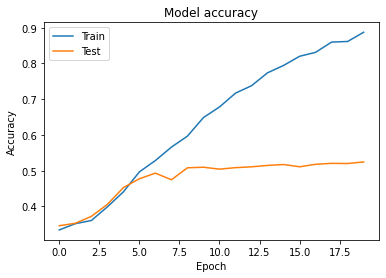

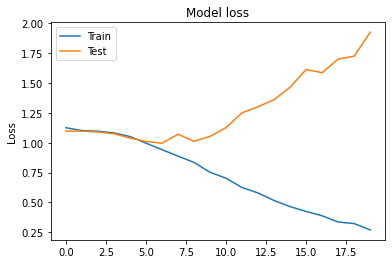


Validating


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 250) dtype=int32>]


6/6 [==============================] - 24s 4s/step

Inferencing
6/6 [==============================] - 8s 1s/step

Fold 1 Accuracy: 0.5246

Connecting to TPU
Running on TPU grpc://10.6.135.194:8470
Initializing TPU


INFO:tensorflow:Initializing the TPU system: grpc://10.6.135.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.135.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.




###################
##### Fold: 2 #####
###################

Tokenizing

Training


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>]


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>]


23/23 [==============================] - ETA: 0s - loss: 1.1297 - sparse_categorical_accuracy: 0.3468

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


23/23 [==============================] - 117s 2s/step - loss: 1.1297 - sparse_categorical_accuracy: 0.3468 - val_loss: 1.0997 - val_sparse_categorical_accuracy: 0.3510
Epoch 2/20
23/23 [==============================] - 13s 590ms/step - loss: 1.1024 - sparse_categorical_accuracy: 0.3499 - val_loss: 1.0977 - val_sparse_categorical_accuracy: 0.3578
Epoch 3/20
23/23 [==============================] - 13s 592ms/step - loss: 1.0889 - sparse_categorical_accuracy: 0.3925 - val_loss: 1.0877 - val_sparse_categorical_accuracy: 0.3903
Epoch 4/20
23/23 [==============================] - 13s 583ms/step - loss: 1.0683 - sparse_categorical_accuracy: 0.4178 - val_loss: 1.0485 - val_sparse_categorical_accuracy: 0.4444
Epoch 5/20
23/23 [==============================] - 13s 578ms/step - loss: 1.0235 - sparse_categorical_accuracy: 0.4664 - val_loss: 1.0181 - val_sparse_categorical_accuracy: 0.4660
Epoch 6/20
23/23 [==============================] - 13s 580ms/step - loss: 0.9798 - sparse_categorical_accur

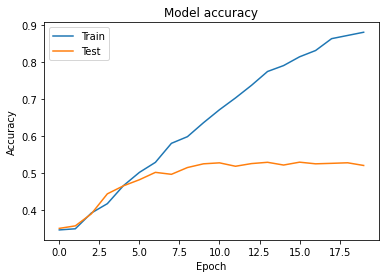

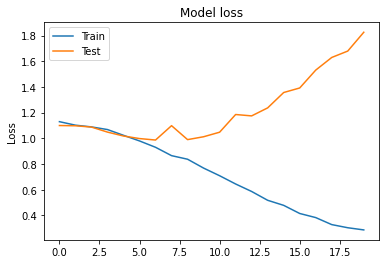


Validating


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 250) dtype=int32>]


6/6 [==============================] - 25s 4s/step

Inferencing
6/6 [==============================] - 8s 1s/step

Fold 2 Accuracy: 0.53


CV Mean Accuracy: 0.5273
CV StdDev Accuracy: 0.0027




Connecting to TPU
Running on TPU grpc://10.6.135.194:8470
Initializing TPU


INFO:tensorflow:Initializing the TPU system: grpc://10.6.135.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.135.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8
adding column for stratified splitting
stratified K-fold on language and label
Connecting to TPU
Running on TPU grpc://10.6.135.194:8470
Initializing TPU


INFO:tensorflow:Initializing the TPU system: grpc://10.6.135.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.135.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 250)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 2307      
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________
None


###################
##### Fold: 1 #####
###################

Tokenizing

Training


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>]


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>]


23/23 [==============================] - ETA: 0s - loss: 1.1218 - sparse_categorical_accuracy: 0.3431

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


23/23 [==============================] - 119s 2s/step - loss: 1.1218 - sparse_categorical_accuracy: 0.3431 - val_loss: 1.1000 - val_sparse_categorical_accuracy: 0.3409
Epoch 2/20
23/23 [==============================] - 13s 578ms/step - loss: 1.1031 - sparse_categorical_accuracy: 0.3319 - val_loss: 1.0993 - val_sparse_categorical_accuracy: 0.3417
Epoch 3/20
23/23 [==============================] - 13s 581ms/step - loss: 1.1032 - sparse_categorical_accuracy: 0.3370 - val_loss: 1.1013 - val_sparse_categorical_accuracy: 0.3429
Epoch 4/20
23/23 [==============================] - 14s 606ms/step - loss: 1.0996 - sparse_categorical_accuracy: 0.3397 - val_loss: 1.1005 - val_sparse_categorical_accuracy: 0.3502
Epoch 5/20
23/23 [==============================] - 14s 616ms/step - loss: 1.1001 - sparse_categorical_accuracy: 0.3376 - val_loss: 1.1028 - val_sparse_categorical_accuracy: 0.3450
Epoch 6/20
23/23 [==============================] - 13s 581ms/step - loss: 1.0980 - sparse_categorical_accur

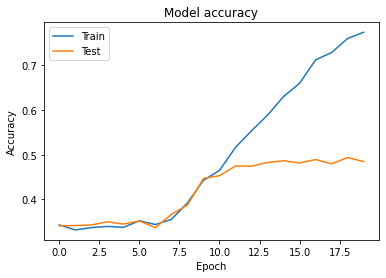

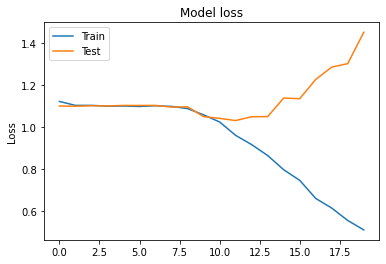


Validating


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 250) dtype=int32>]


6/6 [==============================] - 25s 4s/step

Inferencing
6/6 [==============================] - 9s 1s/step

Fold 1 Accuracy: 0.4939

Connecting to TPU
Running on TPU grpc://10.6.135.194:8470
Initializing TPU


INFO:tensorflow:Initializing the TPU system: grpc://10.6.135.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.135.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.




###################
##### Fold: 2 #####
###################

Tokenizing

Training


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>]


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>]


23/23 [==============================] - ETA: 0s - loss: 1.1387 - sparse_categorical_accuracy: 0.3373

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


23/23 [==============================] - 119s 2s/step - loss: 1.1387 - sparse_categorical_accuracy: 0.3373 - val_loss: 1.1086 - val_sparse_categorical_accuracy: 0.3409
Epoch 2/20
23/23 [==============================] - 14s 617ms/step - loss: 1.1094 - sparse_categorical_accuracy: 0.3276 - val_loss: 1.1041 - val_sparse_categorical_accuracy: 0.3520
Epoch 3/20
23/23 [==============================] - 13s 587ms/step - loss: 1.1043 - sparse_categorical_accuracy: 0.3375 - val_loss: 1.1001 - val_sparse_categorical_accuracy: 0.3442
Epoch 4/20
23/23 [==============================] - 13s 585ms/step - loss: 1.1036 - sparse_categorical_accuracy: 0.3371 - val_loss: 1.0985 - val_sparse_categorical_accuracy: 0.3492
Epoch 5/20
23/23 [==============================] - 13s 577ms/step - loss: 1.0980 - sparse_categorical_accuracy: 0.3558 - val_loss: 1.1004 - val_sparse_categorical_accuracy: 0.3457
Epoch 6/20
23/23 [==============================] - 13s 578ms/step - loss: 1.0995 - sparse_categorical_accur

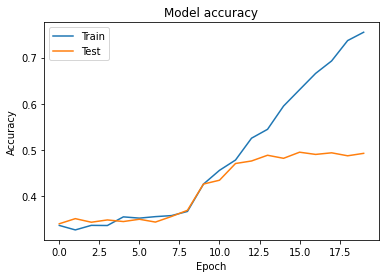

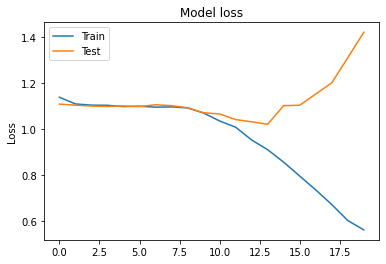


Validating


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 250) dtype=int32>]


6/6 [==============================] - 27s 4s/step

Inferencing
6/6 [==============================] - 8s 1s/step

Fold 2 Accuracy: 0.4955


CV Mean Accuracy: 0.4947
CV StdDev Accuracy: 0.0008




Connecting to TPU
Running on TPU grpc://10.6.135.194:8470
Initializing TPU


INFO:tensorflow:Initializing the TPU system: grpc://10.6.135.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.135.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8
adding column for stratified splitting
stratified K-fold on language and label
Connecting to TPU
Running on TPU grpc://10.6.135.194:8470
Initializing TPU


INFO:tensorflow:Initializing the TPU system: grpc://10.6.135.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.135.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU initialized
REPLICAS: 8


Some layers from the model checkpoint at bert-large-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 250)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 333579264 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 333,582,339
Trainable params: 333,582,339
Non-trainable params: 0
_________________________________________________________________
None


###################
##### Fold: 1 #####
###################

Tokenizing

Training


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>]


Epoch 1/20


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 250) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=int64>]


ResourceExhaustedError: ignored

In [ ]:
# Model: Bert Base Uncased
config_2 = Configuration("bert-base-uncased", "bert_base_uncased.h5", max_length = 250, batch_size = 32, epochs = 20, train_splits = 2)
preds_train_2, preds_test_2 = run_model(config_2)
df_test = pd.read_csv("/content/drive/MyDrive/nlp/data/test.csv")
df_submission = pd.DataFrame({"id": df_test.id.values, "prediction": np.argmax(preds_test_2, axis = 1)})
df_submission.to_csv("/content/drive/MyDrive/nlp/data/Bert_Base_Uncased.csv", index = False)
df_submission.prediction.value_counts()

In [ ]:
# Hyperparameter Space 1
#config_1 = Configuration("bert-base-multilingual-cased", translation = False, max_length = 32, learning_rate = 1e-5, batch_size = 32, epochs = 2, train_splits = 2)
#preds_train_1, preds_test_1 = run_model(config_1)

# Hyperparameter Space 2
#config_2 = Configuration("bert-base-multilingual-cased", translation = False, max_length = 64, learning_rate = 1e-5, batch_size = 32, epochs = 3, train_splits = 2)
#preds_train_2, preds_test_2 = run_model(config_2)

# Hyperparameter Space 3
#config_3 = Configuration("bert-base-multilingual-cased", translation = False, max_length = 84, learning_rate = 1e-5, batch_size = 16, epochs = 4, train_splits = 2)
#preds_train_3, preds_test_3 = run_model(config_3)

# Hyperparameter Space 4
#config_4 = Configuration("bert-base-multilingual-cased", translation = False, max_length = 84, learning_rate = 1e-4, batch_size = 16, epochs = 4, train_splits = 2)
#preds_train_4, preds_test_4 = run_model(config_4)

In [ ]:
# Final Model: XLM Roberta Large
#config_1 = Configuration("jplu/tf-xlm-roberta-large", translation = False, max_length = 84, batch_size = 64, epochs = 16, train_splits = 4)
#preds_train_1, preds_test_1 = run_model(config_1)